In [2]:
# 混合3种攻击（4个不同数据集）的数据集测试
import csv
import os
import math
import numpy as np

'''
input_file1 = open('./Fuzzy.csv', 'r')
input_file2 = open('./DoS.csv', 'r')
input_file3 = open('./SpoofingGEAR.csv', 'r')
input_file4 = open('./SpoofingRPM.csv', 'r')
'''

output_file = open('./multiply.csv', 'w',newline='')
writer_file = csv.writer(output_file)

currentNum=0
totalNum=100000

print("1.Fuzzy")
with open('Fuzzy.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            writer_file.writerow([row[0],row[1],row[2],row[3],row[4]])
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("2.DoS")
with open('DoS.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            writer_file.writerow([row[0],row[1],row[2],row[3],row[4]])
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("3.SpoofingGEAR")
with open('SpoofingGEAR.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            writer_file.writerow([row[0],row[1],row[2],row[3],row[4]])
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("4.SpoofingRPM")
with open('SpoofingRPM.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            writer_file.writerow([row[0],row[1],row[2],row[3],row[4]])
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

output_file.close()
print("done")

1.Fuzzy
2.DoS
3.SpoofingGEAR
4.SpoofingRPM
done



CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'R': 0, 'T': 1}
Starting training 
Epoch 1/20
3500/3500 [==============================] - 28s 8ms/step - loss: 0.0484 - accuracy: 0.9551 - val_loss: 0.0338 - val_accuracy: 0.9672
Epoch 2/20
3500/3500 [==============================] - 27s 8ms/step - loss: 0.0411 - accuracy: 0.9598 - val_loss: 0.0347 - val_accuracy: 0.9653
Epoch 3/20
3500/3500 [==============================] - 27s 8ms/step - loss: 0.0406 - accuracy: 0.9600 - val_loss: 0.0357 - val_accuracy: 0.9647
Epoch 4/20
3500/3500 [==============================] - 27s 8ms/step - loss: 0.0404 - accuracy: 0.9601 - val_loss: 0.0372 - val_accuracy: 0.9632
Epoch 5/20
3500/3500 [==============================] - 27s 8ms/step - loss: 0.0401 - accuracy: 0.9605 - val_loss: 0.0353 - val_accuracy: 0.9657
Epoch 6/20
3500/3500 [==============================] - 27s 8ms/step - loss: 0.0397 - accuracy: 0.9608 - val_loss: 0.0349 - val_accuracy: 0.9653
Epoch 7/20
35

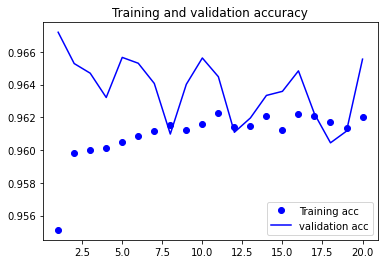

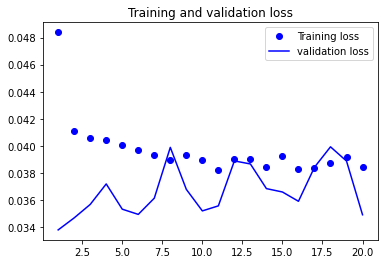

In [5]:
# 混合数据集上的效果测试
import os
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
from keras.layers import LSTM, Dense, Activation,Input,core,Dropout
from keras.models import Model
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# 读取CSV数据集，并拆分为训练集和测试集
# 该函数的传入参数为CSV_FILE_PATH: csv文件路径

def TP(y_true,y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    return TP

def TN(y_true,y_pred):
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    return TN

def FP(y_true,y_pred):
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    return FP

def FN(y_true,y_pred):
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    return FN

class LossHistory(K.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

def load_data(CSV_FILE_PATH):
    CAN = pd.read_csv(CSV_FILE_PATH)
    target_var = 'class'  # 目标变量
    # 数据集的特征
    features = list(CAN.columns)
    features.remove(target_var)
    features.remove('id_dis')
    # 目标变量的类别
    Class = CAN[target_var].unique()
    # 目标变量的类别字典
    Class_dict = dict(zip(Class, range(len(Class))))
    # 增加一列target, 将目标变量进行编码
    CAN['target'] = CAN[target_var].apply(lambda x: Class_dict[x])
    # 对目标变量进行0-1编码(One-hot Encoding)
    lb = LabelBinarizer()
    lb.fit(list(Class_dict.values()))
    transformed_labels = lb.transform(CAN['target'])
    y_bin_labels = []  # 对多分类进行0-1编码的变量
    for i in range(transformed_labels.shape[1]):
        y_bin_labels.append('y' + str(i))
        CAN['y' + str(i)] = transformed_labels[:, i]
    # 将数据集分为训练集和测试集
    train_x, test_x, train_y, test_y = train_test_split(CAN[features], CAN[y_bin_labels], \
                                                        train_size=0.7, test_size=0.3, random_state=0)
    print(type(Class_dict))
    print(Class_dict)
    return train_x, test_x, train_y, test_y, Class_dict


# 0. 开始
print("\nCAN dataset using Keras/TensorFlow ")
np.random.seed(4)
tf.random.set_seed(13)

# 1. 读取CSV数据集
print("Loading CAN data into memory")
CSV_FILE_PATH = 'multiply.csv'
train_x, test_x, train_y, test_y, Class_dict = load_data(CSV_FILE_PATH)
train_x = train_x.values.reshape(train_x.shape[0],1,3)
test_x = test_x.values.reshape(test_x.shape[0],1,3)

# 从训练集中留出验证集
num = int(len(train_x)*0.2)
val_x = train_x[:num]
partial_train_x = train_x[num:]
val_y = train_y[:num]
partial_train_y = train_y[num:]


# 2. 定义模型
init = K.initializers.glorot_uniform(seed=1)
simple_adam = K.optimizers.Adam()
model = K.models.Sequential()
model.add(LSTM(units=256,input_shape=(1, 3),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=32, kernel_initializer=init, activation='linear'))
model.add(Dense(1))
model.add(Activation('tanh'))
#model.add(K.layers.Dense(units=6, kernel_initializer=init, activation='relu'))
#model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='sigmoid'))
#model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])'''
#rmsprop = RMSprop(lr=0.01)
#model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy',TP,TN,FP,FN])
model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy'])
#print(model.summary())
# 3. 训练模型
b_size = 64
max_epochs = 20
# max_epochs = 2
history = LossHistory()
print("Starting training ")
h = model.fit(partial_train_x, partial_train_y, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))
model.save("./lstm_multi.h5")
print("Training finished \n")

# 4. 评估模型
eval = model.evaluate(test_x, test_y, verbose=0)

print('测试集上的loss和acc：')
print(eval)

import matplotlib.pyplot as plt
acc = h.history['accuracy']
loss = h.history['loss']
val_acc = h.history['val_accuracy']
val_loss = h.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
# 尝试多分类
# 1、数据预处理, 4个数据集各取10万条，标签：正常0，Fuzzy1，Dos2，Spoofing3
import csv
import os
import math
import numpy as np

output_file = open('./multiply_mul_class.csv', 'w',newline='')
writer_file = csv.writer(output_file)

currentNum=0
totalNum=100000

print("1.Fuzzy")
with open('Fuzzy.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            if row[-1] == 'R':
                writer_file.writerow([row[0],row[1],row[2],row[3],'T0'])
            else:
                writer_file.writerow([row[0],row[1],row[2],row[3],'T1']) # Fuzzy:1
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("2.DoS")
with open('DoS.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            if row[-1] == 'R':
                writer_file.writerow([row[0],row[1],row[2],row[3],'T0'])
            else:
                writer_file.writerow([row[0],row[1],row[2],row[3],'T2']) # DoS:2
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("3.SpoofingGEAR")
with open('SpoofingGEAR.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            if row[-1] == 'R':
                writer_file.writerow([row[0],row[1],row[2],row[3],'T0'])
            else:
                writer_file.writerow([row[0],row[1],row[2],row[3],'T3']) # Spoofing:3
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("4.SpoofingRPM")
with open('SpoofingRPM.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            if row[-1] == 'R':
                writer_file.writerow([row[0],row[1],row[2],row[3],'T0'])
            else:
                writer_file.writerow([row[0],row[1],row[2],row[3],'T3']) # Spoofing:3
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

output_file.close()
print("done")

1.Fuzzy
2.DoS
3.SpoofingGEAR
4.SpoofingRPM
done



CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1, 'T2': 2, 'T3': 3}
Starting training 
Epoch 1/20
3500/3500 [==============================] - 27s 8ms/step - loss: 0.1208 - accuracy: 0.9631 - val_loss: 0.0889 - val_accuracy: 0.9746
Epoch 2/20
3500/3500 [==============================] - 27s 8ms/step - loss: 0.1071 - accuracy: 0.9686 - val_loss: 0.0921 - val_accuracy: 0.9741
Epoch 3/20
3500/3500 [==============================] - 27s 8ms/step - loss: 0.1028 - accuracy: 0.9697 - val_loss: 0.0811 - val_accuracy: 0.9750
Epoch 4/20
3500/3500 [==============================] - 26s 8ms/step - loss: 0.0985 - accuracy: 0.9710 - val_loss: 0.0869 - val_accuracy: 0.9751
Epoch 5/20
3500/3500 [==============================] - 26s 7ms/step - loss: 0.0955 - accuracy: 0.9722 - val_loss: 0.0789 - val_accuracy: 0.9762
Epoch 6/20
3500/3500 [==============================] - 27s 8ms/step - loss: 0.0951 - accuracy: 0.9725 - val_loss: 0.1075 - val_accuracy: 

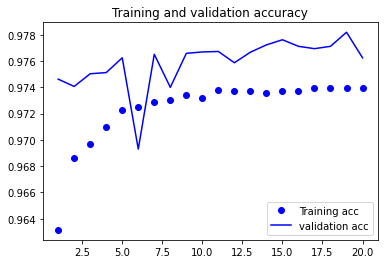

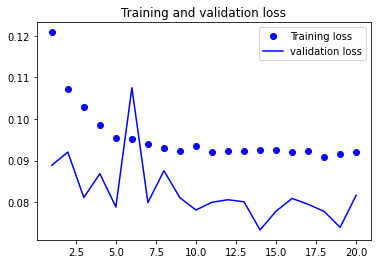

In [25]:
# 混合数据集上的多分类的效果测试
import os
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
from keras.layers import LSTM, Dense, Activation,Input,core,Dropout
from keras.models import Model
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# 读取CSV数据集，并拆分为训练集和测试集
# 该函数的传入参数为CSV_FILE_PATH: csv文件路径

def TP(y_true,y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    return TP

def TN(y_true,y_pred):
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    return TN

def FP(y_true,y_pred):
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    return FP

def FN(y_true,y_pred):
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    return FN

class LossHistory(K.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

def load_data(CSV_FILE_PATH):
    CAN = pd.read_csv(CSV_FILE_PATH)
    target_var = 'class'  # 目标变量
    # 数据集的特征
    features = list(CAN.columns)
    features.remove(target_var)
    features.remove('id_dis')
    # 目标变量的类别
    Class = CAN[target_var].unique()
    # 目标变量的类别字典
    Class_dict = dict(zip(Class, range(len(Class))))
    # 增加一列target, 将目标变量进行编码
    CAN['target'] = CAN[target_var].apply(lambda x: Class_dict[x])
    # 对目标变量进行0-1编码(One-hot Encoding)
    lb = LabelBinarizer()
    lb.fit(list(Class_dict.values()))
    transformed_labels = lb.transform(CAN['target'])
    y_bin_labels = []  # 对多分类进行0-1编码的变量
    for i in range(transformed_labels.shape[1]):
        y_bin_labels.append('y' + str(i))
        CAN['y' + str(i)] = transformed_labels[:, i]
    # 将数据集分为训练集和测试集
    train_x, test_x, train_y, test_y = train_test_split(CAN[features], CAN[y_bin_labels], \
                                                        train_size=0.7, test_size=0.3, random_state=0) # shuffle=True, stratify=None
    print(type(Class_dict))
    print(Class_dict)
    return train_x, test_x, train_y, test_y, Class_dict


# 0. 开始
print("\nCAN dataset using Keras/TensorFlow ")
np.random.seed(4)
tf.random.set_seed(13)

# 1. 读取CSV数据集
print("Loading CAN data into memory")
CSV_FILE_PATH = 'multiply_mul_class.csv'
train_x, test_x, train_y, test_y, Class_dict = load_data(CSV_FILE_PATH)
train_x = train_x.values.reshape(train_x.shape[0],1,3)
test_x = test_x.values.reshape(test_x.shape[0],1,3)

# 从训练集中留出验证集
# train_x = train_x.astype(float)
# test_x = test_x.astype(float)
num = int(len(train_x)*0.2)
val_x = train_x[:num]
partial_train_x = train_x[num:]
val_y = train_y[:num]
partial_train_y = train_y[num:]


# 2. 定义模型
init = K.initializers.glorot_uniform(seed=1)
simple_adam = K.optimizers.Adam()
model = K.models.Sequential()
model.add(LSTM(units=256,input_shape=(1, 3),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=32, kernel_initializer=init, activation='linear'))
model.add(Dense(4,activation='softmax'))
#model.add(Activation('tanh'))
#model.add(K.layers.Dense(units=6, kernel_initializer=init, activation='relu'))
#model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='sigmoid'))
#model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])'''
#rmsprop = RMSprop(lr=0.01)
#model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy',TP,TN,FP,FN])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#print(model.summary())
# 3. 训练模型
b_size = 64
max_epochs = 20
# max_epochs = 2
history = LossHistory()
print("Starting training ")
h = model.fit(partial_train_x, partial_train_y, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))
model.save("./lstm_multi_mul_class.h5")
print("Training finished \n")

# 4. 评估模型
eval = model.evaluate(test_x, test_y, verbose=0)

print('测试集上的loss和acc：')
print(eval)

import matplotlib.pyplot as plt
acc = h.history['accuracy']
loss = h.history['loss']
val_acc = h.history['val_accuracy']
val_loss = h.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
predictions = model.predict(test_x)

In [29]:
predictions[0].shape

(4,)

In [30]:
np.sum(predictions[0])

1.0

In [34]:
predictions[:10]

array([[9.9826568e-01, 5.0142262e-05, 3.7862131e-17, 1.6842408e-03],
       [9.9751747e-01, 9.5855132e-05, 1.4710829e-16, 2.3866717e-03],
       [9.9833447e-01, 4.3905540e-05, 3.4571719e-17, 1.6216416e-03],
       [9.9833471e-01, 4.9440096e-05, 3.1175220e-17, 1.6159423e-03],
       [9.9832398e-01, 4.8468151e-05, 3.3495948e-17, 1.6276175e-03],
       [9.9766880e-01, 5.6941266e-05, 1.5415097e-16, 2.2741901e-03],
       [9.9833351e-01, 4.3714143e-05, 3.4793824e-17, 1.6227973e-03],
       [9.9831176e-01, 4.9037008e-05, 3.4087974e-17, 1.6392245e-03],
       [9.9833870e-01, 4.7821479e-05, 3.2202896e-17, 1.6134233e-03],
       [9.9834323e-01, 4.5970908e-05, 3.2475554e-17, 1.6107801e-03]],
      dtype=float32)

In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1))

array([[95853,   217,     0,  1669],
       [   68,  3617,     0,     0],
       [    1,     0,  7091,     0],
       [  988,     0,     0, 10496]], dtype=int64)

In [48]:
from sklearn.metrics import classification_report
print(classification_report(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     97739
           1       0.94      0.98      0.96      3685
           2       1.00      1.00      1.00      7092
           3       0.86      0.91      0.89     11484

    accuracy                           0.98    120000
   macro avg       0.95      0.97      0.96    120000
weighted avg       0.98      0.98      0.98    120000



In [44]:
type(test_y)

pandas.core.frame.DataFrame

In [45]:
type(predictions)

numpy.ndarray

In [8]:
# 多分类增加输入特征1：数据字段内容
import csv
import os
import math
import numpy as np

def calc_ent(x):
    """
        calculate shanno ent of x
        计算时8个bit为一组，共8组，组内相同或不同来计算信息熵
    """

    x_value_list = set([x[i] for i in range(x.shape[0])])  # 创建一个无序不重复元素集,如{'d8', '00', '8b'}，x.shape[0]=8
    ent = 0.0
    for x_value in x_value_list:
        p = float(x[x == x_value].shape[0]) / x.shape[0]
        logp = np.log2(p)
        ent -= p * logp
    return ent

csvfile=open('./DoS1.csv', 'w',newline='')
writer=csv.writer(csvfile)
writer.writerow(["id","id_num","id_dis","data0","data1","data2","data3","data4","data5","data6","data7","data_c","class"])
id_num={} # id:次数
id_t={}   # id:[时间戳,]
id = "0x000"
# 记录上一个信息熵
data_c = 0
# 数据字段，需要转成十进制
data = []
for i in range(0,8):
    data.append(0)

with open('DoS Attack_dataset.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if "0x"+row[1] not in id_num:
            time = [float(row[0])]
            id_t["0x"+row[1]] = time
            id_num["0x"+row[1]] = len(time) # 字典元素个数
        else:
            time = id_t["0x"+row[1]]
            for i in time:
                if float(row[0]) - i > 1:   # 去除时间间隔超过1s的
                    time.remove(i)
                else:
                    break
            time.append(float(row[0]))
            id_t.update({"0x"+row[1]:time})
            id_num.update({"0x"+row[1]:len(time)})
        id_dis = eval("0x"+row[1])^eval(id) # 与前一个id的异或
        d = calc_ent(np.array(row[3:-1])) # 某条报文数据字段形成的矩阵，如['d8', '00', '00', '8b', '00', '00', '00', '00']
        # 处理数字字段的转换
        num = int(row[2])
        for j in range(0,num):
            data[7-j] = eval("0x"+row[2+num-j])

        # 打标签
        if row[-1] == "R":
            writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],d-data_c,'R'])
        else:
            writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],d-data_c,'T'])
        data_c = d
        id = "0x"+row[1]
        for j in range(0,8):
            data[j]=0
f.close()
csvfile.close()
print("done")


done


In [5]:
data = []
for i in range(0,8):
    data.append(0)
print(data)
data[0]=88
print(data)

[0, 0, 0, 0, 0, 0, 0, 0]
[88, 0, 0, 0, 0, 0, 0, 0]


In [9]:
# 多分类增加输入特征1：数据字段内容
import csv
import os
import math
import numpy as np

def calc_ent(x):
    """
        calculate shanno ent of x
        计算时8个bit为一组，共8组，组内相同或不同来计算信息熵
    """

    x_value_list = set([x[i] for i in range(x.shape[0])])  # 创建一个无序不重复元素集,如{'d8', '00', '8b'}，x.shape[0]=8
    ent = 0.0
    for x_value in x_value_list:
        p = float(x[x == x_value].shape[0]) / x.shape[0]
        logp = np.log2(p)
        ent -= p * logp
    return ent

csvfile=open('./Fuzzy1.csv', 'w',newline='')
writer=csv.writer(csvfile)
writer.writerow(["id","id_num","id_dis","data0","data1","data2","data3","data4","data5","data6","data7","data_c","class"])
id_num={} # id:次数
id_t={}   # id:[时间戳,]
id = "0x000"
# 记录上一个信息熵
data_c = 0
# 数据字段，需要转成十进制
data = []
for i in range(0,8):
    data.append(0)

with open('Fuzzy Attack_dataset.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if "0x"+row[1] not in id_num:
            time = [float(row[0])]
            id_t["0x"+row[1]] = time
            id_num["0x"+row[1]] = len(time) # 字典元素个数
        else:
            time = id_t["0x"+row[1]]
            for i in time:
                if float(row[0]) - i > 1:   # 去除时间间隔超过1s的
                    time.remove(i)
                else:
                    break
            time.append(float(row[0]))
            id_t.update({"0x"+row[1]:time})
            id_num.update({"0x"+row[1]:len(time)})
        id_dis = eval("0x"+row[1])^eval(id) # 与前一个id的异或
        d = calc_ent(np.array(row[3:-1])) # 某条报文数据字段形成的矩阵，如['d8', '00', '00', '8b', '00', '00', '00', '00']
        # 处理数字字段的转换
        num = int(row[2])
        for j in range(0,num):
            data[7-j] = eval("0x"+row[2+num-j])

        # 打标签
        if row[-1] == "R":
            writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],d-data_c,'R'])
        else:
            writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],d-data_c,'T'])
        data_c = d
        id = "0x"+row[1]
        for j in range(0,8):
            data[j]=0
f.close()
csvfile.close()
print("done")


done


In [10]:
# 多分类增加输入特征1：数据字段内容
import csv
import os
import math
import numpy as np

def calc_ent(x):
    """
        calculate shanno ent of x
        计算时8个bit为一组，共8组，组内相同或不同来计算信息熵
    """

    x_value_list = set([x[i] for i in range(x.shape[0])])  # 创建一个无序不重复元素集,如{'d8', '00', '8b'}，x.shape[0]=8
    ent = 0.0
    for x_value in x_value_list:
        p = float(x[x == x_value].shape[0]) / x.shape[0]
        logp = np.log2(p)
        ent -= p * logp
    return ent

csvfile=open('./SpoofingGEAR1.csv', 'w',newline='')
writer=csv.writer(csvfile)
writer.writerow(["id","id_num","id_dis","data0","data1","data2","data3","data4","data5","data6","data7","data_c","class"])
id_num={} # id:次数
id_t={}   # id:[时间戳,]
id = "0x000"
# 记录上一个信息熵
data_c = 0
# 数据字段，需要转成十进制
data = []
for i in range(0,8):
    data.append(0)

with open('Spoofing the drive gear_dataset.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if "0x"+row[1] not in id_num:
            time = [float(row[0])]
            id_t["0x"+row[1]] = time
            id_num["0x"+row[1]] = len(time) # 字典元素个数
        else:
            time = id_t["0x"+row[1]]
            for i in time:
                if float(row[0]) - i > 1:   # 去除时间间隔超过1s的
                    time.remove(i)
                else:
                    break
            time.append(float(row[0]))
            id_t.update({"0x"+row[1]:time})
            id_num.update({"0x"+row[1]:len(time)})
        id_dis = eval("0x"+row[1])^eval(id) # 与前一个id的异或
        d = calc_ent(np.array(row[3:-1])) # 某条报文数据字段形成的矩阵，如['d8', '00', '00', '8b', '00', '00', '00', '00']
        # 处理数字字段的转换
        num = int(row[2])
        for j in range(0,num):
            data[7-j] = eval("0x"+row[2+num-j])

        # 打标签
        if row[-1] == "R":
            writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],d-data_c,'R'])
        else:
            writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],d-data_c,'T'])
        data_c = d
        id = "0x"+row[1]
        for j in range(0,8):
            data[j]=0
f.close()
csvfile.close()
print("done")


done


In [11]:
# 多分类增加输入特征1：数据字段内容
import csv
import os
import math
import numpy as np

def calc_ent(x):
    """
        calculate shanno ent of x
        计算时8个bit为一组，共8组，组内相同或不同来计算信息熵
    """

    x_value_list = set([x[i] for i in range(x.shape[0])])  # 创建一个无序不重复元素集,如{'d8', '00', '8b'}，x.shape[0]=8
    ent = 0.0
    for x_value in x_value_list:
        p = float(x[x == x_value].shape[0]) / x.shape[0]
        logp = np.log2(p)
        ent -= p * logp
    return ent

csvfile=open('./SpoofingRPM1.csv', 'w',newline='')
writer=csv.writer(csvfile)
writer.writerow(["id","id_num","id_dis","data0","data1","data2","data3","data4","data5","data6","data7","data_c","class"])
id_num={} # id:次数
id_t={}   # id:[时间戳,]
id = "0x000"
# 记录上一个信息熵
data_c = 0
# 数据字段，需要转成十进制
data = []
for i in range(0,8):
    data.append(0)

with open('Spoofing the RPM gauge_dataset.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if "0x"+row[1] not in id_num:
            time = [float(row[0])]
            id_t["0x"+row[1]] = time
            id_num["0x"+row[1]] = len(time) # 字典元素个数
        else:
            time = id_t["0x"+row[1]]
            for i in time:
                if float(row[0]) - i > 1:   # 去除时间间隔超过1s的
                    time.remove(i)
                else:
                    break
            time.append(float(row[0]))
            id_t.update({"0x"+row[1]:time})
            id_num.update({"0x"+row[1]:len(time)})
        id_dis = eval("0x"+row[1])^eval(id) # 与前一个id的异或
        d = calc_ent(np.array(row[3:-1])) # 某条报文数据字段形成的矩阵，如['d8', '00', '00', '8b', '00', '00', '00', '00']
        # 处理数字字段的转换
        num = int(row[2])
        for j in range(0,num):
            data[7-j] = eval("0x"+row[2+num-j])

        # 打标签
        if row[-1] == "R":
            writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],d-data_c,'R'])
        else:
            writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],d-data_c,'T'])
        data_c = d
        id = "0x"+row[1]
        for j in range(0,8):
            data[j]=0
f.close()
csvfile.close()
print("done")


done


In [12]:
# 混合3种攻击（4个不同数据集）的数据集测试
import csv
import os
import math
import numpy as np

'''
input_file1 = open('./Fuzzy.csv', 'r')
input_file2 = open('./DoS.csv', 'r')
input_file3 = open('./SpoofingGEAR.csv', 'r')
input_file4 = open('./SpoofingRPM.csv', 'r')
'''

output_file = open('./multiply1.csv', 'w',newline='')
writer_file = csv.writer(output_file)

currentNum=0
totalNum=100000

print("1.Fuzzy")
with open('Fuzzy1.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],row[12]])
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("2.DoS")
with open('DoS1.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],row[12]])
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("3.SpoofingGEAR")
with open('SpoofingGEAR1.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],row[12]])
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("4.SpoofingRPM")
with open('SpoofingRPM1.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],row[12]])
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

output_file.close()
print("done")

1.Fuzzy
2.DoS
3.SpoofingGEAR
4.SpoofingRPM
done


In [14]:
# 尝试多分类
# 1、数据预处理, 4个数据集各取10万条，标签：正常0，Fuzzy1，Dos2，Spoofing3
import csv
import os
import math
import numpy as np

output_file = open('./multiply_mul_class.csv', 'w',newline='')
writer_file = csv.writer(output_file)

currentNum=0
totalNum=100000

print("1.Fuzzy")
with open('Fuzzy1.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            if row[-1] == 'R':
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],'T0'])
            else:
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],'T1']) # Fuzzy:1
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("2.DoS")
with open('DoS1.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            if row[-1] == 'R':
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],'T0'])
            else:
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],'T2']) # DoS:2
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("3.SpoofingGEAR")
with open('SpoofingGEAR1.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            if row[-1] == 'R':
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],'T0'])
            else:
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],'T3']) # Spoofing:3
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("4.SpoofingRPM")
with open('SpoofingRPM1.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            if row[-1] == 'R':
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],'T0'])
            else:
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],'T3']) # Spoofing:3
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

output_file.close()
print("done")

1.Fuzzy
2.DoS
3.SpoofingGEAR
4.SpoofingRPM
done



CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1, 'T2': 2, 'T3': 3}
Starting training 
Epoch 1/20
3500/3500 [==============================] - 29s 8ms/step - loss: 0.2411 - accuracy: 0.9140 - val_loss: 0.1622 - val_accuracy: 0.9460
Epoch 2/20
3500/3500 [==============================] - 28s 8ms/step - loss: 0.1777 - accuracy: 0.9420 - val_loss: 0.1371 - val_accuracy: 0.9585
Epoch 3/20
3500/3500 [==============================] - 27s 8ms/step - loss: 0.1626 - accuracy: 0.9485 - val_loss: 0.1609 - val_accuracy: 0.9520
Epoch 4/20
3500/3500 [==============================] - 27s 8ms/step - loss: 0.1544 - accuracy: 0.9527 - val_loss: 0.1294 - val_accuracy: 0.9623
Epoch 5/20
3500/3500 [==============================] - 27s 8ms/step - loss: 0.1496 - accuracy: 0.9547 - val_loss: 0.1223 - val_accuracy: 0.9648
Epoch 6/20
3500/3500 [==============================] - 27s 8ms/step - loss: 0.1446 - accuracy: 0.9569 - val_loss: 0.1238 - val_accuracy: 

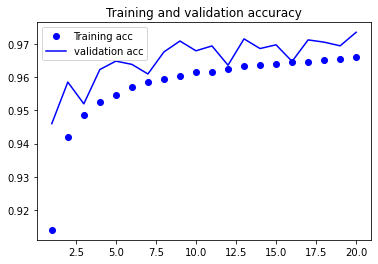

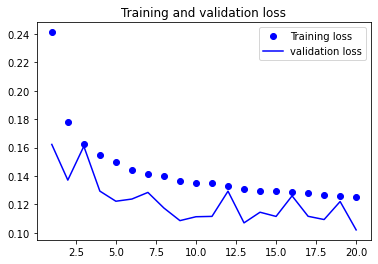

In [16]:
# 混合数据集上的多分类的效果测试
import os
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
from keras.layers import LSTM, Dense, Activation,Input,core,Dropout
from keras.models import Model
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# 读取CSV数据集，并拆分为训练集和测试集
# 该函数的传入参数为CSV_FILE_PATH: csv文件路径

def TP(y_true,y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    return TP

def TN(y_true,y_pred):
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    return TN

def FP(y_true,y_pred):
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    return FP

def FN(y_true,y_pred):
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    return FN

class LossHistory(K.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

def load_data(CSV_FILE_PATH):
    CAN = pd.read_csv(CSV_FILE_PATH)
    target_var = 'class'  # 目标变量
    # 数据集的特征
    features = list(CAN.columns)
    features.remove(target_var)
    features.remove('id_dis')
    # 目标变量的类别
    Class = CAN[target_var].unique()
    # 目标变量的类别字典
    Class_dict = dict(zip(Class, range(len(Class))))
    # 增加一列target, 将目标变量进行编码
    CAN['target'] = CAN[target_var].apply(lambda x: Class_dict[x])
    # 对目标变量进行0-1编码(One-hot Encoding)
    lb = LabelBinarizer()
    lb.fit(list(Class_dict.values()))
    transformed_labels = lb.transform(CAN['target'])
    y_bin_labels = []  # 对多分类进行0-1编码的变量
    for i in range(transformed_labels.shape[1]):
        y_bin_labels.append('y' + str(i))
        CAN['y' + str(i)] = transformed_labels[:, i]
    # 将数据集分为训练集和测试集
    train_x, test_x, train_y, test_y = train_test_split(CAN[features], CAN[y_bin_labels], \
                                                        train_size=0.7, test_size=0.3, random_state=0) # shuffle=True, stratify=None
    print(type(Class_dict))
    print(Class_dict)
    return train_x, test_x, train_y, test_y, Class_dict


# 0. 开始
print("\nCAN dataset using Keras/TensorFlow ")
np.random.seed(4)
tf.random.set_seed(13)

# 1. 读取CSV数据集
print("Loading CAN data into memory")
CSV_FILE_PATH = 'multiply_mul_class.csv'
train_x, test_x, train_y, test_y, Class_dict = load_data(CSV_FILE_PATH)
train_x = train_x.values.reshape(train_x.shape[0],1,11)
test_x = test_x.values.reshape(test_x.shape[0],1,11)

# 从训练集中留出验证集
# train_x = train_x.astype(float)
# test_x = test_x.astype(float)
num = int(len(train_x)*0.2)
val_x = train_x[:num]
partial_train_x = train_x[num:]
val_y = train_y[:num]
partial_train_y = train_y[num:]


# 2. 定义模型
init = K.initializers.glorot_uniform(seed=1)
simple_adam = K.optimizers.Adam()
model = K.models.Sequential()
model.add(LSTM(units=256,input_shape=(1, 11),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=32, kernel_initializer=init, activation='linear'))
model.add(Dense(4,activation='softmax'))
#model.add(Activation('tanh'))
#model.add(K.layers.Dense(units=6, kernel_initializer=init, activation='relu'))
#model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='sigmoid'))
#model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])'''
#rmsprop = RMSprop(lr=0.01)
#model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy',TP,TN,FP,FN])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#print(model.summary())
# 3. 训练模型
b_size = 64
max_epochs = 20
# max_epochs = 2
history = LossHistory()
print("Starting training ")
h = model.fit(partial_train_x, partial_train_y, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))
model.save("./lstm_multi_mul_class.h5")
print("Training finished \n")

# 4. 评估模型
eval = model.evaluate(test_x, test_y, verbose=0)

print('测试集上的loss和acc：')
print(eval)

import matplotlib.pyplot as plt
acc = h.history['accuracy']
loss = h.history['loss']
val_acc = h.history['val_accuracy']
val_loss = h.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
predictions = model.predict(test_x)
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1))
print(confusion_matrix)
from sklearn.metrics import classification_report
print(classification_report(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1)))

<function confusion_matrix at 0x00000289140F20D8>
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     73705
           1       0.99      0.99      0.99      3685
           2       1.00      1.00      1.00      7163
           3       1.00      0.91      0.95     35446

    accuracy                           0.97    119999
   macro avg       0.99      0.97      0.98    119999
weighted avg       0.97      0.97      0.97    119999



In [19]:
confusion_matrix(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1))

array([[73642,     4,     0,    59],
       [   48,  3637,     0,     0],
       [    0,     0,  7163,     0],
       [ 3196,    16,     0, 32234]], dtype=int64)

In [23]:
id_t['0x316'][-1]

1478191605.0

In [24]:
id_num['0x316']

642

In [49]:
# 多分类增加输入特征2：上一条报文的id，与上一条报文的时间间隔, 与同id上一条报文的时间间隔和信息熵之差
import csv
import os
import math
import numpy as np

def calc_ent(x):
    """
        calculate shanno ent of x
        计算时8个bit为一组，共8组，组内相同或不同来计算信息熵
    """

    x_value_list = set([x[i] for i in range(x.shape[0])])  # 创建一个无序不重复元素集,如{'d8', '00', '8b'}，x.shape[0]=8
    ent = 0.0
    for x_value in x_value_list:
        p = float(x[x == x_value].shape[0]) / x.shape[0]
        logp = np.log2(p)
        ent -= p * logp
    return ent

csvfile=open('./SpoofingGEAR2.csv', 'w',newline='')
writer=csv.writer(csvfile)
writer.writerow(["id","id_num","id_dis","last_id","last_interval","interval",
                 "data0","data1","data2","data3","data4","data5","data6","data7","data_c","data_last","class"])
id_num={} # id:次数
id_t={}   # id:[时间戳,]
idd = "0x000"
# 上一条时间
last_time = 0
# 同id的上一条报文信息字典
last_same_id = {}
# 记录上一个信息熵
data_c = 0
# 数据字段，需要转成十进制
data = []
for i in range(0,8):
    data.append(0)

with open('Spoofing the drive gear_dataset.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if "0x"+row[1] not in id_num:
            time = [float(row[0])]
            id_t["0x"+row[1]] = time
            id_num["0x"+row[1]] = len(time) # 字典元素个数
            last_same_id["0x"+row[1]] = 0
            interval = 0
        else:
            time = id_t["0x"+row[1]]
            interval = float(row[0]) - time[-1]
            for i in time:
                if float(row[0]) - i > 1:   # 去除时间间隔超过1s的
                    time.remove(i)
                else:
                    break
            time.append(float(row[0]))
            id_t.update({"0x"+row[1]:time})
            id_num.update({"0x"+row[1]:len(time)})
            # last_same_id.update({"0x"+row[1]:calc_ent(np.array(row[3:-1]))})
        last_interval = float(row[0]) - last_time
        id_dis = eval("0x"+row[1])^eval(idd) # 与前一个id的异或
        d = calc_ent(np.array(row[3:-1])) # 某条报文数据字段形成的矩阵，如['d8', '00', '00', '8b', '00', '00', '00', '00']
        # 处理数字字段的转换
        num = int(row[2])
        for j in range(0,num):
            data[7-j] = eval("0x"+row[2+num-j])

        # 打标签
        if row[-1] == "R":
            writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,eval(idd),last_interval,interval,
                             data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],d-data_c,last_same_id["0x"+row[1]]-data_c,'R'])
        else:
            writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,eval(idd),last_interval,interval,
                             data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],d-data_c,last_same_id["0x"+row[1]]-data_c,'T'])
        data_c = d
        idd = "0x"+row[1]
        for j in range(0,8):
            data[j]=0
        last_time = float(row[0])
        last_same_id.update({"0x"+row[1]:calc_ent(np.array(row[3:-1]))})
f.close()
csvfile.close()
print("done")


done


In [48]:
row

['R']

In [41]:
float(1478201209.058944)

1478201209.058944

In [42]:
time

[1478191603.0,
 1478191603.0,
 1478191603.0,
 1478191603.0,
 1478191603.0,
 1478191603.0,
 1478191603.0,
 1478191603.0,
 1478191603.0,
 1478191603.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 1478191604.0,
 147819160

In [45]:
# 多分类增加输入特征2：上一条报文的id，与上一条报文的时间间隔, 与同id上一条报文的时间间隔和信息熵之差
import csv
import os
import math
import numpy as np

def calc_ent(x):
    """
        calculate shanno ent of x
        计算时8个bit为一组，共8组，组内相同或不同来计算信息熵
    """

    x_value_list = set([x[i] for i in range(x.shape[0])])  # 创建一个无序不重复元素集,如{'d8', '00', '8b'}，x.shape[0]=8
    ent = 0.0
    for x_value in x_value_list:
        p = float(x[x == x_value].shape[0]) / x.shape[0]
        logp = np.log2(p)
        ent -= p * logp
    return ent

csvfile=open('./DoS2.csv', 'w',newline='')
writer=csv.writer(csvfile)
writer.writerow(["id","id_num","id_dis","last_id","last_interval","interval",
                 "data0","data1","data2","data3","data4","data5","data6","data7","data_c","data_last","class"])
id_num={} # id:次数
id_t={}   # id:[时间戳,]
idd = "0x000"
# 上一条时间
last_time = 0
# 同id的上一条报文信息字典
last_same_id = {}
# 记录上一个信息熵
data_c = 0
# 数据字段，需要转成十进制
data = []
for i in range(0,8):
    data.append(0)

with open('DoS Attack_dataset.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if "0x"+row[1] not in id_num:
            time = [float(row[0])]
            id_t["0x"+row[1]] = time
            id_num["0x"+row[1]] = len(time) # 字典元素个数
            last_same_id["0x"+row[1]] = 0
            interval = 0
        else:
            time = id_t["0x"+row[1]]
            interval = float(row[0]) - time[-1]
            for i in time:
                if float(row[0]) - i > 1:   # 去除时间间隔超过1s的
                    time.remove(i)
                else:
                    break
            time.append(float(row[0]))
            id_t.update({"0x"+row[1]:time})
            id_num.update({"0x"+row[1]:len(time)})
            # last_same_id.update({"0x"+row[1]:calc_ent(np.array(row[3:-1]))})
        last_interval = float(row[0]) - last_time
        id_dis = eval("0x"+row[1])^eval(idd) # 与前一个id的异或
        d = calc_ent(np.array(row[3:-1])) # 某条报文数据字段形成的矩阵，如['d8', '00', '00', '8b', '00', '00', '00', '00']
        # 处理数字字段的转换
        num = int(row[2])
        for j in range(0,num):
            data[7-j] = eval("0x"+row[2+num-j])

        # 打标签
        if row[-1] == "R":
            writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,eval(idd),last_interval,interval,
                             data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],d-data_c,last_same_id["0x"+row[1]]-data_c,'R'])
        else:
            writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,eval(idd),last_interval,interval,
                             data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],d-data_c,last_same_id["0x"+row[1]]-data_c,'T'])
        data_c = d
        idd = "0x"+row[1]
        for j in range(0,8):
            data[j]=0
        last_time = float(row[0])
        last_same_id.update({"0x"+row[1]:calc_ent(np.array(row[3:-1]))})
f.close()
csvfile.close()
print("done")

done


In [50]:
# 多分类增加输入特征2：上一条报文的id，与上一条报文的时间间隔, 与同id上一条报文的时间间隔和信息熵之差
import csv
import os
import math
import numpy as np

def calc_ent(x):
    """
        calculate shanno ent of x
        计算时8个bit为一组，共8组，组内相同或不同来计算信息熵
    """

    x_value_list = set([x[i] for i in range(x.shape[0])])  # 创建一个无序不重复元素集,如{'d8', '00', '8b'}，x.shape[0]=8
    ent = 0.0
    for x_value in x_value_list:
        p = float(x[x == x_value].shape[0]) / x.shape[0]
        logp = np.log2(p)
        ent -= p * logp
    return ent

csvfile=open('./Fuzzy2.csv', 'w',newline='')
writer=csv.writer(csvfile)
writer.writerow(["id","id_num","id_dis","last_id","last_interval","interval",
                 "data0","data1","data2","data3","data4","data5","data6","data7","data_c","data_last","class"])
id_num={} # id:次数
id_t={}   # id:[时间戳,]
idd = "0x000"
# 上一条时间
last_time = 0
# 同id的上一条报文信息字典
last_same_id = {}
# 记录上一个信息熵
data_c = 0
# 数据字段，需要转成十进制
data = []
for i in range(0,8):
    data.append(0)

with open('Fuzzy Attack_dataset.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if "0x"+row[1] not in id_num:
            time = [float(row[0])]
            id_t["0x"+row[1]] = time
            id_num["0x"+row[1]] = len(time) # 字典元素个数
            last_same_id["0x"+row[1]] = 0
            interval = 0
        else:
            time = id_t["0x"+row[1]]
            interval = float(row[0]) - time[-1]
            for i in time:
                if float(row[0]) - i > 1:   # 去除时间间隔超过1s的
                    time.remove(i)
                else:
                    break
            time.append(float(row[0]))
            id_t.update({"0x"+row[1]:time})
            id_num.update({"0x"+row[1]:len(time)})
            # last_same_id.update({"0x"+row[1]:calc_ent(np.array(row[3:-1]))})
        last_interval = float(row[0]) - last_time
        id_dis = eval("0x"+row[1])^eval(idd) # 与前一个id的异或
        d = calc_ent(np.array(row[3:-1])) # 某条报文数据字段形成的矩阵，如['d8', '00', '00', '8b', '00', '00', '00', '00']
        # 处理数字字段的转换
        num = int(row[2])
        for j in range(0,num):
            data[7-j] = eval("0x"+row[2+num-j])

        # 打标签
        if row[-1] == "R":
            writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,eval(idd),last_interval,interval,
                             data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],d-data_c,last_same_id["0x"+row[1]]-data_c,'R'])
        else:
            writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,eval(idd),last_interval,interval,
                             data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],d-data_c,last_same_id["0x"+row[1]]-data_c,'T'])
        data_c = d
        idd = "0x"+row[1]
        for j in range(0,8):
            data[j]=0
        last_time = float(row[0])
        last_same_id.update({"0x"+row[1]:calc_ent(np.array(row[3:-1]))})
f.close()
csvfile.close()
print("done")

done


In [51]:
# 混合3种攻击（4个不同数据集）的数据集测试
import csv
import os
import math
import numpy as np

'''
input_file1 = open('./Fuzzy.csv', 'r')
input_file2 = open('./DoS.csv', 'r')
input_file3 = open('./SpoofingGEAR.csv', 'r')
input_file4 = open('./SpoofingRPM.csv', 'r')
'''

output_file = open('./multiply2.csv', 'w',newline='')
writer_file = csv.writer(output_file)

currentNum=0
totalNum=200000

print("1.Fuzzy")
with open('Fuzzy2.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16]])
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("2.DoS")
with open('DoS2.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16]])
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("3.SpoofingGEAR")
with open('SpoofingGEAR2.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16]])
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

output_file.close()
print("done")

1.Fuzzy
2.DoS
3.SpoofingGEAR
done


In [52]:
# 尝试多分类
# 1、数据预处理, 4个数据集各取10万条，标签：正常0，Fuzzy1，Dos2，Spoofing3
import csv
import os
import math
import numpy as np

output_file = open('./multiply_mul_class2.csv', 'w',newline='')
writer_file = csv.writer(output_file)

currentNum=0
totalNum=100000

print("1.Fuzzy")
with open('Fuzzy2.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            if row[-1] == 'R':
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],'T0'])
            else:
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],'T1']) # Fuzzy:1
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("2.DoS")
with open('DoS2.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            if row[-1] == 'R':
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],'T0'])
            else:
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],'T2']) # DoS:2
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("3.SpoofingGEAR")
with open('SpoofingGEAR2.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            if row[-1] == 'R':
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],'T0'])
            else:
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],'T3']) # Spoofing:3
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

output_file.close()
print("done")

1.Fuzzy
2.DoS
3.SpoofingGEAR
done



CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1, 'T2': 2, 'T3': 3}
Starting training 
Epoch 1/20
2625/2625 [==============================] - 21s 8ms/step - loss: 0.0363 - accuracy: 0.9899 - val_loss: 0.0106 - val_accuracy: 0.9977
Epoch 2/20
2625/2625 [==============================] - 20s 8ms/step - loss: 0.0098 - accuracy: 0.9977 - val_loss: 0.0048 - val_accuracy: 0.9989
Epoch 3/20
2625/2625 [==============================] - 20s 8ms/step - loss: 0.0092 - accuracy: 0.9981 - val_loss: 0.0058 - val_accuracy: 0.9986
Epoch 4/20
2625/2625 [==============================] - 20s 8ms/step - loss: 0.0081 - accuracy: 0.9985 - val_loss: 0.0031 - val_accuracy: 0.9995
Epoch 5/20
2625/2625 [==============================] - 20s 8ms/step - loss: 0.0081 - accuracy: 0.9984 - val_loss: 0.0049 - val_accuracy: 0.9990
Epoch 6/20
2625/2625 [==============================] - 20s 8ms/step - loss: 0.0068 - accuracy: 0.9986 - val_loss: 0.0026 - val_accuracy: 

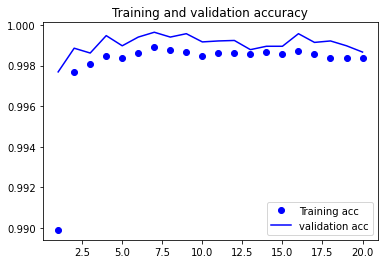

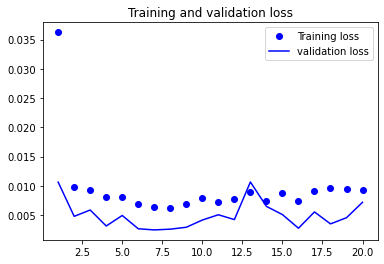

In [53]:
# 混合数据集上的多分类的效果测试
import os
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
from keras.layers import LSTM, Dense, Activation,Input,core,Dropout
from keras.models import Model
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# 读取CSV数据集，并拆分为训练集和测试集
# 该函数的传入参数为CSV_FILE_PATH: csv文件路径

def TP(y_true,y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    return TP

def TN(y_true,y_pred):
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    return TN

def FP(y_true,y_pred):
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    return FP

def FN(y_true,y_pred):
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    return FN

class LossHistory(K.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

def load_data(CSV_FILE_PATH):
    CAN = pd.read_csv(CSV_FILE_PATH)
    target_var = 'class'  # 目标变量
    # 数据集的特征
    features = list(CAN.columns)
    features.remove(target_var)
    features.remove('id_dis')
    # 目标变量的类别
    Class = CAN[target_var].unique()
    # 目标变量的类别字典
    Class_dict = dict(zip(Class, range(len(Class))))
    # 增加一列target, 将目标变量进行编码
    CAN['target'] = CAN[target_var].apply(lambda x: Class_dict[x])
    # 对目标变量进行0-1编码(One-hot Encoding)
    lb = LabelBinarizer()
    lb.fit(list(Class_dict.values()))
    transformed_labels = lb.transform(CAN['target'])
    y_bin_labels = []  # 对多分类进行0-1编码的变量
    for i in range(transformed_labels.shape[1]):
        y_bin_labels.append('y' + str(i))
        CAN['y' + str(i)] = transformed_labels[:, i]
    # 将数据集分为训练集和测试集
    train_x, test_x, train_y, test_y = train_test_split(CAN[features], CAN[y_bin_labels], \
                                                        train_size=0.7, test_size=0.3, random_state=0) # shuffle=True, stratify=None
    print(type(Class_dict))
    print(Class_dict)
    return train_x, test_x, train_y, test_y, Class_dict


# 0. 开始
print("\nCAN dataset using Keras/TensorFlow ")
np.random.seed(4)
tf.random.set_seed(13)

# 1. 读取CSV数据集
print("Loading CAN data into memory")
CSV_FILE_PATH = 'multiply_mul_class2.csv'
train_x, test_x, train_y, test_y, Class_dict = load_data(CSV_FILE_PATH)
train_x = train_x.values.reshape(train_x.shape[0],1,15)
test_x = test_x.values.reshape(test_x.shape[0],1,15)

# 从训练集中留出验证集
# train_x = train_x.astype(float)
# test_x = test_x.astype(float)
num = int(len(train_x)*0.2)
val_x = train_x[:num]
partial_train_x = train_x[num:]
val_y = train_y[:num]
partial_train_y = train_y[num:]


# 2. 定义模型
init = K.initializers.glorot_uniform(seed=1)
simple_adam = K.optimizers.Adam()
model = K.models.Sequential()
model.add(LSTM(units=256,input_shape=(1, 15),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=32, kernel_initializer=init, activation='linear'))
model.add(Dense(4,activation='softmax'))
#model.add(Activation('tanh'))
#model.add(K.layers.Dense(units=6, kernel_initializer=init, activation='relu'))
#model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='sigmoid'))
#model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])'''
#rmsprop = RMSprop(lr=0.01)
#model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy',TP,TN,FP,FN])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#print(model.summary())
# 3. 训练模型
b_size = 64
max_epochs = 20
# max_epochs = 2
history = LossHistory()
print("Starting training ")
h = model.fit(partial_train_x, partial_train_y, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))
model.save("./lstm_multi_mul_class2.h5")
print("Training finished \n")

# 4. 评估模型
eval2 = model.evaluate(test_x, test_y, verbose=0)

print('测试集上的loss和acc：')
print(eval)

import matplotlib.pyplot as plt
acc = h.history['accuracy']
loss = h.history['loss']
val_acc = h.history['val_accuracy']
val_loss = h.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [54]:
predictions = model.predict(test_x)
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1))
print(confusion_matrix)
from sklearn.metrics import classification_report
print(classification_report(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1)))

<function confusion_matrix at 0x00000289140F20D8>
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     73550
           1       0.98      0.99      0.98      3640
           2       1.00      1.00      1.00      7173
           3       1.00      1.00      1.00      5637

    accuracy                           1.00     90000
   macro avg       0.99      1.00      1.00     90000
weighted avg       1.00      1.00      1.00     90000



In [56]:
confusion_matrix(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1))

array([[73461,    89,     0,     0],
       [   35,  3605,     0,     0],
       [    0,     0,  7173,     0],
       [    0,     0,     0,  5637]], dtype=int64)


CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1, 'T2': 2, 'T3': 3}
Starting training 
Epoch 1/20
2625/2625 [==============================] - 44s 17ms/step - loss: 0.1255 - accuracy: 0.9636 - val_loss: 0.0862 - val_accuracy: 0.9788
Epoch 2/20
2625/2625 [==============================] - 27s 10ms/step - loss: 0.0936 - accuracy: 0.9759 - val_loss: 0.0747 - val_accuracy: 0.9813
Epoch 3/20
2625/2625 [==============================] - 21s 8ms/step - loss: 0.0884 - accuracy: 0.9778 - val_loss: 0.0867 - val_accuracy: 0.9795
Epoch 4/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.0861 - accuracy: 0.9787 - val_loss: 0.0757 - val_accuracy: 0.9803
Epoch 5/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.0829 - accuracy: 0.9791 - val_loss: 0.0766 - val_accuracy: 0.9805
Epoch 6/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.0816 - accuracy: 0.9797 - val_loss: 0.0711 - val_accuracy

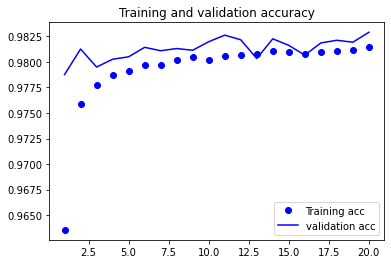

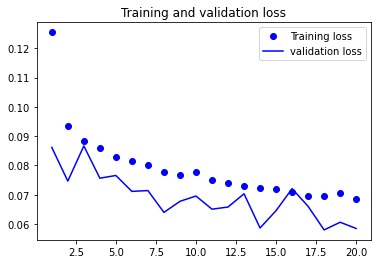

In [57]:
# 混合数据集上的多分类的效果测试
import os
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
from keras.layers import LSTM, Dense, Activation,Input,core,Dropout
from keras.models import Model
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# 读取CSV数据集，并拆分为训练集和测试集
# 该函数的传入参数为CSV_FILE_PATH: csv文件路径

def TP(y_true,y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    return TP

def TN(y_true,y_pred):
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    return TN

def FP(y_true,y_pred):
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    return FP

def FN(y_true,y_pred):
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    return FN

class LossHistory(K.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

def load_data(CSV_FILE_PATH):
    CAN = pd.read_csv(CSV_FILE_PATH)
    target_var = 'class'  # 目标变量
    # 数据集的特征
    features = list(CAN.columns)
    features.remove(target_var)
    features.remove('id_dis')
    features.remove('data0')
    features.remove('data1')
    features.remove('data2')
    features.remove('data3')
    features.remove('data4')
    features.remove('data5')
    features.remove('data6')
    features.remove('data7')
    # 目标变量的类别
    Class = CAN[target_var].unique()
    # 目标变量的类别字典
    Class_dict = dict(zip(Class, range(len(Class))))
    # 增加一列target, 将目标变量进行编码
    CAN['target'] = CAN[target_var].apply(lambda x: Class_dict[x])
    # 对目标变量进行0-1编码(One-hot Encoding)
    lb = LabelBinarizer()
    lb.fit(list(Class_dict.values()))
    transformed_labels = lb.transform(CAN['target'])
    y_bin_labels = []  # 对多分类进行0-1编码的变量
    for i in range(transformed_labels.shape[1]):
        y_bin_labels.append('y' + str(i))
        CAN['y' + str(i)] = transformed_labels[:, i]
    # 将数据集分为训练集和测试集
    train_x, test_x, train_y, test_y = train_test_split(CAN[features], CAN[y_bin_labels], \
                                                        train_size=0.7, test_size=0.3, random_state=0) # shuffle=True, stratify=None
    print(type(Class_dict))
    print(Class_dict)
    return train_x, test_x, train_y, test_y, Class_dict


# 0. 开始
print("\nCAN dataset using Keras/TensorFlow ")
np.random.seed(4)
tf.random.set_seed(13)

# 1. 读取CSV数据集
print("Loading CAN data into memory")
CSV_FILE_PATH = 'multiply_mul_class2.csv'
train_x, test_x, train_y, test_y, Class_dict = load_data(CSV_FILE_PATH)
train_x = train_x.values.reshape(train_x.shape[0],1,7)
test_x = test_x.values.reshape(test_x.shape[0],1,7)

# 从训练集中留出验证集
# train_x = train_x.astype(float)
# test_x = test_x.astype(float)
num = int(len(train_x)*0.2)
val_x = train_x[:num]
partial_train_x = train_x[num:]
val_y = train_y[:num]
partial_train_y = train_y[num:]


# 2. 定义模型
init = K.initializers.glorot_uniform(seed=1)
simple_adam = K.optimizers.Adam()
model = K.models.Sequential()
model.add(LSTM(units=256,input_shape=(1, 7),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=32, kernel_initializer=init, activation='linear'))
model.add(Dense(4,activation='softmax'))
#model.add(Activation('tanh'))
#model.add(K.layers.Dense(units=6, kernel_initializer=init, activation='relu'))
#model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='sigmoid'))
#model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])'''
#rmsprop = RMSprop(lr=0.01)
#model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy',TP,TN,FP,FN])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#print(model.summary())
# 3. 训练模型
b_size = 64
max_epochs = 20
# max_epochs = 2
history = LossHistory()
print("Starting training ")
h = model.fit(partial_train_x, partial_train_y, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))
model.save("./lstm_multi_mul_class2_1.h5")
print("Training finished \n")

# 4. 评估模型
eval2 = model.evaluate(test_x, test_y, verbose=0)

print('测试集上的loss和acc：')
print(eval)

import matplotlib.pyplot as plt
acc = h.history['accuracy']
loss = h.history['loss']
val_acc = h.history['val_accuracy']
val_loss = h.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [58]:
predictions = model.predict(test_x)
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1))
print(confusion_matrix)
from sklearn.metrics import classification_report
print(classification_report(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1)))

<function confusion_matrix at 0x00000289140F20D8>
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     73550
           1       0.92      0.98      0.95      3640
           2       1.00      1.00      1.00      7173
           3       0.88      0.94      0.91      5637

    accuracy                           0.98     90000
   macro avg       0.95      0.98      0.96     90000
weighted avg       0.98      0.98      0.98     90000



In [59]:
confusion_matrix(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1))

array([[72478,   328,     1,   743],
       [   67,  3573,     0,     0],
       [    0,     0,  7173,     0],
       [  333,     0,     0,  5304]], dtype=int64)

In [1]:
# 尝试多分类
# 1、数据预处理, 4个数据集各取10万条，标签：正常0，Fuzzy1，Dos2，Spoofing3
import csv
import os
import math
import numpy as np

output_file = open('./multiply_mul_class2_2.csv', 'w',newline='')
writer_file = csv.writer(output_file)

currentNum=0
totalNum=300000

print("1.Fuzzy")
with open('Fuzzy2.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            if row[-1] == 'R':
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],'T0'])
            else:
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],'T1']) # Fuzzy:1
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("2.DoS")
with open('DoS2.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            if row[-1] == 'R':
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],'T0'])
            else:
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],'T2']) # DoS:2
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("3.SpoofingGEAR")
with open('SpoofingGEAR2.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            if row[-1] == 'R':
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],'T0'])
            else:
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],'T3']) # Spoofing:3
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

output_file.close()
print("done")

1.Fuzzy
2.DoS
3.SpoofingGEAR
done



CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1, 'T2': 2, 'T3': 3}
Starting training 
Epoch 1/20
7875/7875 [==============================] - 61s 8ms/step - loss: 0.0186 - accuracy: 0.9950 - val_loss: 0.0049 - val_accuracy: 0.9991
Epoch 2/20
7875/7875 [==============================] - 61s 8ms/step - loss: 0.0078 - accuracy: 0.9985 - val_loss: 0.0057 - val_accuracy: 0.9990
Epoch 3/20
7875/7875 [==============================] - 60s 8ms/step - loss: 0.0078 - accuracy: 0.9986 - val_loss: 0.0042 - val_accuracy: 0.9993
Epoch 4/20
7875/7875 [==============================] - 62s 8ms/step - loss: 0.0077 - accuracy: 0.9986 - val_loss: 0.0032 - val_accuracy: 0.9994
Epoch 5/20
7875/7875 [==============================] - 63s 8ms/step - loss: 0.0070 - accuracy: 0.9988 - val_loss: 0.0037 - val_accuracy: 0.9994
Epoch 6/20
7875/7875 [==============================] - 62s 8ms/step - loss: 0.0085 - accuracy: 0.9986 - val_loss: 0.0042 - val_accuracy: 

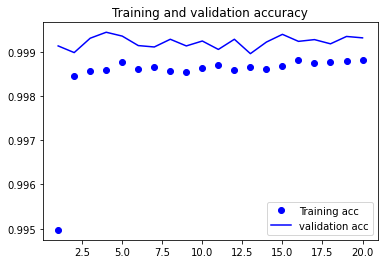

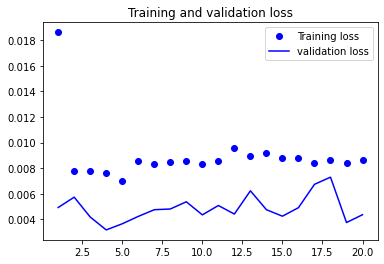

In [2]:
# 混合数据集上的多分类的效果测试
import os
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
from keras.layers import LSTM, Dense, Activation,Input,core,Dropout
from keras.models import Model
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# 读取CSV数据集，并拆分为训练集和测试集
# 该函数的传入参数为CSV_FILE_PATH: csv文件路径

def TP(y_true,y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    return TP

def TN(y_true,y_pred):
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    return TN

def FP(y_true,y_pred):
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    return FP

def FN(y_true,y_pred):
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    return FN

class LossHistory(K.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

def load_data(CSV_FILE_PATH):
    CAN = pd.read_csv(CSV_FILE_PATH)
    target_var = 'class'  # 目标变量
    # 数据集的特征
    features = list(CAN.columns)
    features.remove(target_var)
    features.remove('id_dis')
    # 目标变量的类别
    Class = CAN[target_var].unique()
    # 目标变量的类别字典
    Class_dict = dict(zip(Class, range(len(Class))))
    # 增加一列target, 将目标变量进行编码
    CAN['target'] = CAN[target_var].apply(lambda x: Class_dict[x])
    # 对目标变量进行0-1编码(One-hot Encoding)
    lb = LabelBinarizer()
    lb.fit(list(Class_dict.values()))
    transformed_labels = lb.transform(CAN['target'])
    y_bin_labels = []  # 对多分类进行0-1编码的变量
    for i in range(transformed_labels.shape[1]):
        y_bin_labels.append('y' + str(i))
        CAN['y' + str(i)] = transformed_labels[:, i]
    # 将数据集分为训练集和测试集
    train_x, test_x, train_y, test_y = train_test_split(CAN[features], CAN[y_bin_labels], \
                                                        train_size=0.7, test_size=0.3, random_state=0) # shuffle=True, stratify=None
    print(type(Class_dict))
    print(Class_dict)
    return train_x, test_x, train_y, test_y, Class_dict


# 0. 开始
print("\nCAN dataset using Keras/TensorFlow ")
np.random.seed(4)
tf.random.set_seed(13)

# 1. 读取CSV数据集
print("Loading CAN data into memory")
CSV_FILE_PATH = 'multiply_mul_class2_2.csv'
train_x, test_x, train_y, test_y, Class_dict = load_data(CSV_FILE_PATH)
train_x = train_x.values.reshape(train_x.shape[0],1,15)
test_x = test_x.values.reshape(test_x.shape[0],1,15)

# 从训练集中留出验证集
# train_x = train_x.astype(float)
# test_x = test_x.astype(float)
num = int(len(train_x)*0.2)
val_x = train_x[:num]
partial_train_x = train_x[num:]
val_y = train_y[:num]
partial_train_y = train_y[num:]


# 2. 定义模型
init = K.initializers.glorot_uniform(seed=1)
simple_adam = K.optimizers.Adam()
model = K.models.Sequential()
model.add(LSTM(units=256,input_shape=(1, 15),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=32, kernel_initializer=init, activation='linear'))
model.add(Dense(4,activation='softmax'))
#model.add(Activation('tanh'))
#model.add(K.layers.Dense(units=6, kernel_initializer=init, activation='relu'))
#model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='sigmoid'))
#model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])'''
#rmsprop = RMSprop(lr=0.01)
#model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy',TP,TN,FP,FN])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#print(model.summary())
# 3. 训练模型
b_size = 64
max_epochs = 20
# max_epochs = 2
history = LossHistory()
print("Starting training ")
h = model.fit(partial_train_x, partial_train_y, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))
model.save("./lstm_multi_mul_class2_2.h5")
print("Training finished \n")

# 4. 评估模型
eval2 = model.evaluate(test_x, test_y, verbose=0)

print('测试集上的loss和acc：')
print(eval2)

import matplotlib.pyplot as plt
acc = h.history['accuracy']
loss = h.history['loss']
val_acc = h.history['val_accuracy']
val_loss = h.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [5]:
print('测试集上的loss和acc：')
print(eval2)

测试集上的loss和acc：
[0.005623411387205124, 0.9991815090179443]


In [3]:
predictions = model.predict(test_x)
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1))
print(confusion_matrix)
from sklearn.metrics import classification_report
print(classification_report(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1)))

<function confusion_matrix at 0x000001D85A9F0CA8>
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    218948
           1       0.99      0.99      0.99     14920
           2       1.00      1.00      1.00     20368
           3       1.00      1.00      1.00     15764

    accuracy                           1.00    270000
   macro avg       1.00      1.00      1.00    270000
weighted avg       1.00      1.00      1.00    270000



In [ ]:
confusion_matrix(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1))

In [1]:
# 多分类增加输入特征2：上一条报文的id，与上一条报文的时间间隔, 与同id上一条报文的时间间隔和信息熵之差
# 加入特征3：之前是否出现过isFirst
# 信息熵改为：二进制异或，1的个数（即不同的位数来体现差异性）
import csv
import os
import math
import numpy as np

def process_new2(input_file, output_file):
    csvfile=open(output_file, 'w',newline='')
    writer=csv.writer(csvfile)
    #writer.writerow(["id","id_num","id_dis","last_id","last_interval","interval",
                     #"data0","data1","data2","data3","data4","data5","data6","data7","data_c","data_last","isFirst","class"])
    id_num={} # id:次数
    id_t={}   # id:[时间戳,]
    id_data={} # id:[数据字段] 不管重不重复，按顺序记录
    # id_data2={} # id:[数据字段], 不管重不重复，按顺序记录
    # 上一条id
    idd = "0x000"
    # 上一条时间
    last_time = 0
    # 同id的上一条报文信息字典
    #last_same_id = {}
    # 记录上一个信息熵
    #data_c = 0
    # 数据字段，需要转成十进制
    data = []
    for i in range(0,8):
        data.append(0)
    # 上一条报文的数据字段、上一条同id报文的数据字段
    last_data = '0x0000000000000000'
    last_id_data = '0x0000000000000000'

    with open(input_file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            # isFirst, 数据字段之前是否出现过, 1代表是第一次出现
            isFirst = 1
            # 处理数字字段的转换
            num = int(row[2])
            # 拼接数据字段得到的字符串
            dataString = ''
            for j in range(0,num):
                data[7-j] = eval("0x"+row[2+num-j])
                dataString = dataString + row[2+num-j]   
            # 第一次出现该id    
            if "0x"+row[1] not in id_num:
                time = [float(row[0])]
                dlc = [dataString]
                id_t["0x"+row[1]] = time
                id_data["0x"+row[1]] = dlc
                id_num["0x"+row[1]] = len(time) # 字典元素个数
                # last_same_id["0x"+row[1]] = 0
                interval = 0
                last_id_data = '0x0000000000000000'
            # 之前出现过该id
            else:
                time = id_t["0x"+row[1]]
                dlc = id_data["0x"+row[1]]
                last_id_data = '0x' + dlc[-1] 
                interval = float(row[0]) - time[-1]
                for i in time:
                    if float(row[0]) - i > 1:   # 去除时间间隔超过1s的
                        time.remove(i)
                    else:
                        break
                time.append(float(row[0]))
                if dataString not in dlc: # 数据字段之前没有出现过
                    isFirst = 1
                else:
                    isFirst = 0
                dlc.append(dataString)
                id_data.update({"0x"+row[1]:dlc})
                id_t.update({"0x"+row[1]:time})
                id_num.update({"0x"+row[1]:len(time)})
                # last_same_id.update({"0x"+row[1]:calc_ent(np.array(row[3:-1]))})
            last_interval = float(row[0]) - last_time
            id_dis = eval("0x"+row[1])^eval(idd) # 与前一个id的异或
            # d = calc_ent(np.array(row[3:-1])) # 某条报文数据字段形成的矩阵，如['d8', '00', '00', '8b', '00', '00', '00', '00']

            # 打标签
            if row[-1] == "R":
                writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,eval(idd),last_interval,interval,
                                 data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],
                                 bin(int('0x'+dataString,16)^int(last_data,16)).count('1'),
                                 bin(int('0x'+dataString,16)^int(last_id_data,16)).count('1'),isFirst,'R'])
            else:
                writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,eval(idd),last_interval,interval,
                                 data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],
                                 bin(int('0x'+dataString,16)^int(last_data,16)).count('1'),
                                 bin(int('0x'+dataString,16)^int(last_id_data,16)).count('1'),isFirst,'T'])
            # data_c = d
            idd = "0x"+row[1]
            for j in range(0,8):
                data[j]=0
            last_time = float(row[0])
            #last_same_id.update({"0x"+row[1]:calc_ent(np.array(row[3:-1]))})
            last_data = '0x' + dataString 
    f.close()
    csvfile.close()
    print("done")

In [2]:
process_new2('DoS Attack_dataset.csv','DoS3.csv')
process_new2('Fuzzy Attack_dataset.csv','Fuzzy3.csv')
process_new2('Spoofing the drive gear_dataset.csv','SpoofingGEAR3.csv')

done
done


KeyboardInterrupt: 

In [3]:
# 尝试多分类
# 1、数据预处理, 4个数据集各取30万条，标签：正常0，Fuzzy1，Dos2，Spoofing3
import csv
import os
import math
import numpy as np

output_file = open('./multiply_mul_class2_3.csv', 'w',newline='')
writer_file = csv.writer(output_file)
writer_file.writerow(["id","id_num","id_dis","last_id","last_interval","interval",
                     "data0","data1","data2","data3","data4","data5","data6","data7","data_c","data_last","isFirst","class"])

currentNum=0
totalNum=300000

print("1.Fuzzy")
with open('Fuzzy3.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            if row[-1] == 'R':
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
            else:
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T1']) # Fuzzy:1
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("2.DoS")
with open('DoS3.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            if row[-1] == 'R':
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
            else:
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T2']) # DoS:2
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("3.SpoofingGEAR")
with open('SpoofingGEAR3.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        if currentNum < totalNum:
            if row[-1] == 'R':
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
            else:
                writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T3']) # Spoofing:3
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

output_file.close()
print("done")

1.Fuzzy
2.DoS
3.SpoofingGEAR
done



CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1, 'T2': 2, 'T3': 3}
Starting training 
Epoch 1/20
7875/7875 [==============================] - 59s 7ms/step - loss: 0.0161 - accuracy: 0.9959 - val_loss: 0.0035 - val_accuracy: 0.9994
Epoch 2/20
7875/7875 [==============================] - 57s 7ms/step - loss: 0.0065 - accuracy: 0.9988 - val_loss: 0.0059 - val_accuracy: 0.9991
Epoch 3/20
7875/7875 [==============================] - 57s 7ms/step - loss: 0.0053 - accuracy: 0.9991 - val_loss: 0.0026 - val_accuracy: 0.9997
Epoch 4/20
7875/7875 [==============================] - 56s 7ms/step - loss: 0.0056 - accuracy: 0.9991 - val_loss: 0.0024 - val_accuracy: 0.9996
Epoch 5/20
7875/7875 [==============================] - 57s 7ms/step - loss: 0.0061 - accuracy: 0.9990 - val_loss: 0.0025 - val_accuracy: 0.9996
Epoch 6/20
7875/7875 [==============================] - 57s 7ms/step - loss: 0.0062 - accuracy: 0.9990 - val_loss: 0.0064 - val_accuracy: 

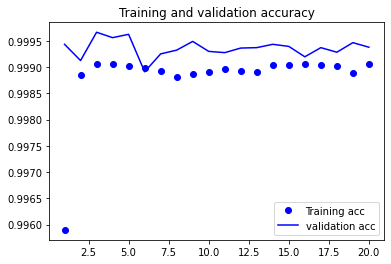

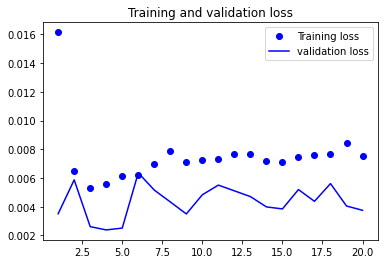

In [5]:
# 混合数据集上的多分类的效果测试
import os
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
from keras.layers import LSTM, Dense, Activation,Input,core,Dropout
from keras.models import Model
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# 读取CSV数据集，并拆分为训练集和测试集
# 该函数的传入参数为CSV_FILE_PATH: csv文件路径

def TP(y_true,y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    return TP

def TN(y_true,y_pred):
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    return TN

def FP(y_true,y_pred):
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    return FP

def FN(y_true,y_pred):
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    return FN

class LossHistory(K.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

def load_data(CSV_FILE_PATH):
    CAN = pd.read_csv(CSV_FILE_PATH)
    target_var = 'class'  # 目标变量
    # 数据集的特征
    features = list(CAN.columns)
    features.remove(target_var)
    features.remove('id_dis')
    # 目标变量的类别
    Class = CAN[target_var].unique()
    # 目标变量的类别字典
    Class_dict = dict(zip(Class, range(len(Class))))
    # 增加一列target, 将目标变量进行编码
    CAN['target'] = CAN[target_var].apply(lambda x: Class_dict[x])
    # 对目标变量进行0-1编码(One-hot Encoding)
    lb = LabelBinarizer()
    lb.fit(list(Class_dict.values()))
    transformed_labels = lb.transform(CAN['target'])
    y_bin_labels = []  # 对多分类进行0-1编码的变量
    for i in range(transformed_labels.shape[1]):
        y_bin_labels.append('y' + str(i))
        CAN['y' + str(i)] = transformed_labels[:, i]
    # 将数据集分为训练集和测试集
    train_x, test_x, train_y, test_y = train_test_split(CAN[features], CAN[y_bin_labels], \
                                                        train_size=0.7, test_size=0.3, random_state=0) # shuffle=True, stratify=None
    print(type(Class_dict))
    print(Class_dict)
    return train_x, test_x, train_y, test_y, Class_dict


# 0. 开始
print("\nCAN dataset using Keras/TensorFlow ")
np.random.seed(4)
tf.random.set_seed(13)

# 1. 读取CSV数据集
print("Loading CAN data into memory")
CSV_FILE_PATH = './multiply_mul_class2_3.csv'
train_x, test_x, train_y, test_y, Class_dict = load_data(CSV_FILE_PATH)
train_x = train_x.values.reshape(train_x.shape[0],1,16)
test_x = test_x.values.reshape(test_x.shape[0],1,16)

# 从训练集中留出验证集
# train_x = train_x.astype(float)
# test_x = test_x.astype(float)
num = int(len(train_x)*0.2)
val_x = train_x[:num]
partial_train_x = train_x[num:]
val_y = train_y[:num]
partial_train_y = train_y[num:]


# 2. 定义模型
init = K.initializers.glorot_uniform(seed=1)
simple_adam = K.optimizers.Adam()
model = K.models.Sequential()
model.add(LSTM(units=256,input_shape=(1, 16),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=32, kernel_initializer=init, activation='linear'))
model.add(Dense(4,activation='softmax'))
#model.add(Activation('tanh'))
#model.add(K.layers.Dense(units=6, kernel_initializer=init, activation='relu'))
#model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='sigmoid'))
#model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])'''
#rmsprop = RMSprop(lr=0.01)
#model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy',TP,TN,FP,FN])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#print(model.summary())
# 3. 训练模型
b_size = 64
max_epochs = 20
# max_epochs = 2
history = LossHistory()
print("Starting training ")
h = model.fit(partial_train_x, partial_train_y, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))
model.save("./lstm_multi_mul_class3.h5")
print("Training finished \n")

# 4. 评估模型
eval2 = model.evaluate(test_x, test_y, verbose=0)

print('测试集上的loss和acc：')
print(eval2)

import matplotlib.pyplot as plt
acc = h.history['accuracy']
loss = h.history['loss']
val_acc = h.history['val_accuracy']
val_loss = h.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [6]:
predictions = model.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    218948
           1       1.00      0.99      0.99     14920
           2       1.00      1.00      1.00     20368
           3       1.00      1.00      1.00     15764

    accuracy                           1.00    270000
   macro avg       1.00      1.00      1.00    270000
weighted avg       1.00      1.00      1.00    270000



In [7]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1))

array([[218905,     35,      0,      8],
       [   128,  14792,      0,      0],
       [     0,      0,  20368,      0],
       [     3,      0,      0,  15761]], dtype=int64)